In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
from torchvision.models import MobileNet_V3_Small_Weights
import os
import copy
import time

In [2]:
 # === 1. Setup dan Konfigurasi ===
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image

class CSVImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform


        self.class_to_idx = {'hoax': 0, 'valid': 1}
        self.classes = ['hoax', 'valid'] 

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Ambil relative path dari CSV dan perbaiki format slash jika perlu
        img_name = self.data_frame.iloc[idx]['image_path']
        # Mengganti backslash windows (\) dengan forward slash linux (/) jika ada
        img_name = img_name.replace('\\', '/')

        # Gabungkan dengan root directory
        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError) as e:
            raise e

        # Ambil label dari kolom 'label'
        label_str = self.data_frame.iloc[idx]['label']
        label = self.class_to_idx[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label

# === 2. Setup Path dan Dataset ===

# Path ke file CSV dan Root folder
# Sesuaikan ROOT_DIR dengan lokasi di mana folder 'data' berada di Drive Anda
# Contoh: Jika di CSV pathnya "data/raw/...", maka ROOT_DIR adalah folder induk dari "data"
CSV_PATH = r"D:\INDONERIS-DATAMINING\multimodal-hoax-detection\data\training\multimodal_splits\image_only_dataset.csv"
ROOT_DIR = r"D:\INDONERIS-DATAMINING\multimodal-hoax-detection" 

# Inisialisasi Dataset Penuh
full_dataset = CSVImageDataset(
    csv_file=CSV_PATH,
    root_dir=ROOT_DIR,
    transform=None # Transformasi akan diaplikasikan di Subset nanti
)

class_names = full_dataset.classes
print("Classes:", class_names)

# Konfigurasi model dan training
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
SPLIT_RATIO = 0.8 # 80% data untuk training, 20% untuk validasi

Classes: ['hoax', 'valid']


In [3]:
# === 2. Tentukan Device (GPU/CPU) ===
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda:0


In [4]:
# === 3. Tentukan Transformasi Gambar ===
# Normalisasi untuk model ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transformasi untuk training (dengan augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    normalize,
])

# Transformasi untuk validasi (tanpa augmentasi)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

In [5]:
# === 3. Split Train/Val dan Apply Transform ===

total_size = len(full_dataset)
train_size = int(total_size * SPLIT_RATIO)
val_size = total_size - train_size

# Split index
generator = torch.Generator().manual_seed(42)
train_idx, val_idx = torch.utils.data.random_split(
    range(total_size),
    [train_size, val_size],
    generator=generator
)

# Kita perlu wrapper khusus untuk mengaplikasikan transform yang berbeda
# (augmentasi untuk train, standar untuk val) karena dataset aslinya satu.
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Buat Subset dengan Transformasi yang sesuai
train_dataset = SubsetWithTransform(Subset(full_dataset, train_idx.indices), transform=train_transforms)
val_dataset = SubsetWithTransform(Subset(full_dataset, val_idx.indices), transform=val_transforms)

# Buat DataLoader
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False),
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

print("Train size:", dataset_sizes["train"])
print("Val size:", dataset_sizes["val"])

Train size: 2617
Val size: 655


# MobileNetV3small

In [6]:
print("Loading MobileNetV3 Small...")

weights = MobileNet_V3_Small_Weights.DEFAULT
model = models.mobilenet_v3_small(weights=weights)

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier last layer
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, len(class_names))

model = model.to(device)


Loading MobileNetV3 Small...


In [7]:
# === 7. Tentukan Optimizer dan Loss Function ===
params_to_update = model.classifier.parameters()
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()

In [8]:
from tqdm import tqdm
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def train_model_tf_style(model, criterion, optimizer, epochs=10):
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    # History seperti TensorFlow
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                print("Training:")
            else:
                model.eval()
                print("Validation:")

            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase], desc=f"{phase}", ncols=100)

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

                batch_loss = running_loss / dataset_sizes[phase]
                batch_acc = running_corrects.double() / dataset_sizes[phase]

                pbar.set_postfix({"loss": f"{batch_loss:.4f}",
                                  "acc": f"{batch_acc:.4f}"})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} — Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

            # simpan history
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

                # simpan model terbaik
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_wts, r"D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\image_baseline/best_mobilenetv3_tf_style.pth")
                    print("✓ Model terbaik disimpan")

    model.load_state_dict(best_wts)
    return model, history

In [9]:
model, history = train_model_tf_style(model, criterion, optimizer, epochs=10)



Epoch 1/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:56<00:00,  1.44it/s, loss=0.3409, acc=0.8697]


train — Loss: 0.3409, Acc: 0.8697
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:13<00:00,  1.58it/s, loss=0.2096, acc=0.9313]


val — Loss: 0.2096, Acc: 0.9313
✓ Model terbaik disimpan

Epoch 2/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:33<00:00,  2.42it/s, loss=0.2047, acc=0.9259]


train — Loss: 0.2047, Acc: 0.9259
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.86it/s, loss=0.1408, acc=0.9450]


val — Loss: 0.1408, Acc: 0.9450
✓ Model terbaik disimpan

Epoch 3/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:38<00:00,  2.11it/s, loss=0.1477, acc=0.9519]


train — Loss: 0.1477, Acc: 0.9519
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.66it/s, loss=0.1171, acc=0.9496]


val — Loss: 0.1171, Acc: 0.9496
✓ Model terbaik disimpan

Epoch 4/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:37<00:00,  2.19it/s, loss=0.1410, acc=0.9522]


train — Loss: 0.1410, Acc: 0.9522
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.66it/s, loss=0.0993, acc=0.9603]


val — Loss: 0.0993, Acc: 0.9603
✓ Model terbaik disimpan

Epoch 5/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:35<00:00,  2.28it/s, loss=0.1212, acc=0.9633]


train — Loss: 0.1212, Acc: 0.9633
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s, loss=0.0921, acc=0.9588]


val — Loss: 0.0921, Acc: 0.9588

Epoch 6/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:34<00:00,  2.37it/s, loss=0.1292, acc=0.9549]


train — Loss: 0.1292, Acc: 0.9549
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.89it/s, loss=0.0967, acc=0.9511]


val — Loss: 0.0967, Acc: 0.9511

Epoch 7/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:34<00:00,  2.36it/s, loss=0.1063, acc=0.9645]


train — Loss: 0.1063, Acc: 0.9645
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.96it/s, loss=0.0883, acc=0.9542]


val — Loss: 0.0883, Acc: 0.9542

Epoch 8/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:34<00:00,  2.34it/s, loss=0.1105, acc=0.9587]


train — Loss: 0.1105, Acc: 0.9587
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:06<00:00,  3.02it/s, loss=0.0897, acc=0.9557]


val — Loss: 0.0897, Acc: 0.9557

Epoch 9/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:33<00:00,  2.43it/s, loss=0.1062, acc=0.9610]


train — Loss: 0.1062, Acc: 0.9610
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.99it/s, loss=0.0825, acc=0.9603]


val — Loss: 0.0825, Acc: 0.9603

Epoch 10/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:33<00:00,  2.46it/s, loss=0.1041, acc=0.9626]


train — Loss: 0.1041, Acc: 0.9626
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s, loss=0.0952, acc=0.9542]

val — Loss: 0.0952, Acc: 0.9542


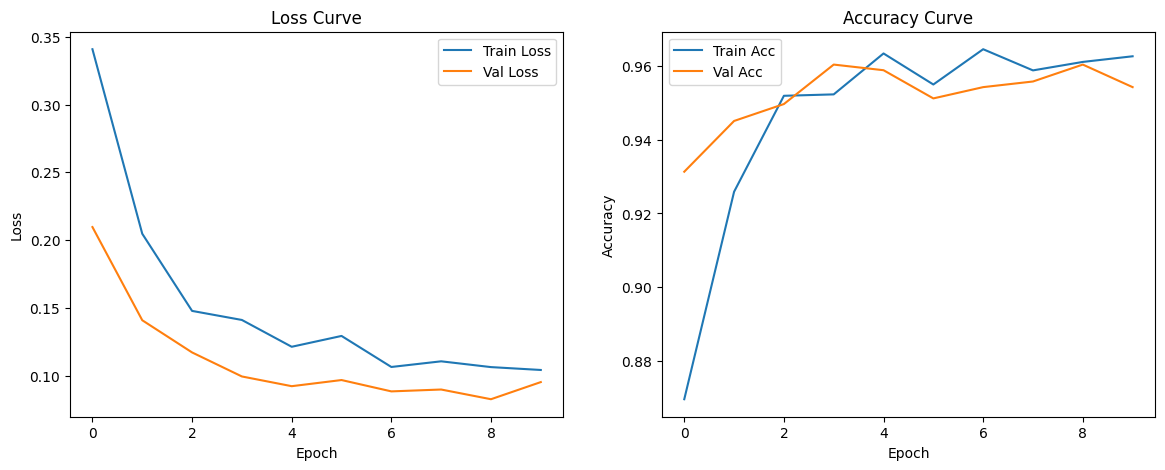

In [10]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [11]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in dataloaders["val"]:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        hoax       0.95      0.94      0.94       235
       valid       0.97      0.97      0.97       420

    accuracy                           0.96       655
   macro avg       0.96      0.96      0.96       655
weighted avg       0.96      0.96      0.96       655



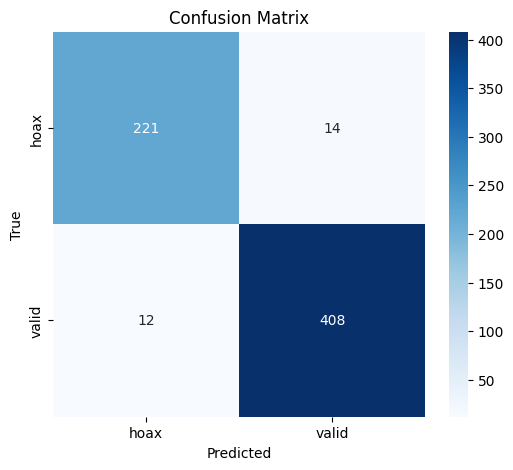

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


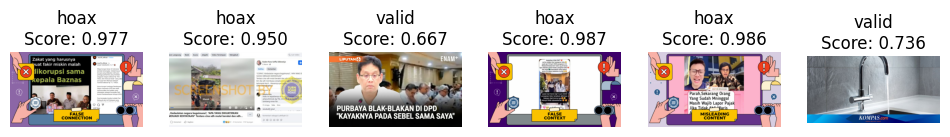

In [24]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch

def predict_image(image_path, model, class_names):
    # Load image
    image = Image.open(image_path).convert("RGB")

    input_tensor = val_transforms(image)
    # Add batch dimension (C, H, W) -> (1, C, H, W)
    input_batch = input_tensor.unsqueeze(0)

    # Move input to the same device as the model
    input_batch = input_batch.to(device)

    # Ensure model is in evaluation mode
    model.eval()

    with torch.no_grad():
        outputs = model(input_batch)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        # Get the predicted class index and its probability
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class_name = class_names[predicted_idx.item()]
        score = probabilities[predicted_idx.item()].item()

    return predicted_class_name, score

model.eval()
model.to(device)

image_paths = []
for root, _, files in os.walk(ROOT_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg",".webp")):
            image_paths.append(os.path.join(root, file))

if not image_paths:
    print("No images found in DATA_DIR. Please check your DATA_DIR path or image formats.")
else:
    # Ambil 3 gambar random (atau kurang jika tidak cukup)
    num_samples = min(6, len(image_paths))
    if num_samples == 0:
        print("Cannot sample images as no images were found.")
    else:
        sample_images = random.sample(image_paths, num_samples)

        plt.figure(figsize=(12, 4))

        for i, img_path in enumerate(sample_images):
            # Use the existing PyTorch prediction function
            label, score = predict_image(img_path, model, class_names)

            # For displaying the image with matplotlib
            img_display = Image.open(img_path).convert("RGB")

            plt.subplot(1, num_samples, i+1) # Adjust subplot based on actual number of samples
            plt.imshow(img_display)
            plt.title(f"{label}\nScore: {score:.3f}")
            plt.axis("off")

        plt.show()

# RESNET50v2

In [14]:
print("Loading ResNet50 v2...")
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace classifier last layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_names))

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

Loading ResNet50 v2...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:19<00:00, 5.19MB/s]


In [15]:
# === 7. Tentukan Optimizer dan Loss Function ===
params_to_update = model.fc.parameters()
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()

In [16]:
from tqdm import tqdm
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def train_model_tf_style(model, criterion, optimizer, epochs=10):
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    # History seperti TensorFlow
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                print("Training:")
            else:
                model.eval()
                print("Validation:")

            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloaders[phase], desc=f"{phase}", ncols=100)

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

                batch_loss = running_loss / dataset_sizes[phase]
                batch_acc = running_corrects.double() / dataset_sizes[phase]

                pbar.set_postfix({"loss": f"{batch_loss:.4f}",
                                  "acc": f"{batch_acc:.4f}"})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} — Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

            # simpan history
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

                # simpan model terbaik
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_wts, r"D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\image_baseline/best_retnet50v2_tf_style.pth")
                    print("✓ Model terbaik disimpan")

    model.load_state_dict(best_wts)
    return model, history

In [17]:
model, history = train_model_tf_style(model, criterion, optimizer, epochs=10)



Epoch 1/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:42<00:00,  1.93it/s, loss=0.5499, acc=0.8051]


train — Loss: 0.5499, Acc: 0.8051
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.28it/s, loss=0.4609, acc=0.8870]


val — Loss: 0.4609, Acc: 0.8870
✓ Model terbaik disimpan

Epoch 2/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:42<00:00,  1.93it/s, loss=0.3869, acc=0.8919]


train — Loss: 0.3869, Acc: 0.8919
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.30it/s, loss=0.3701, acc=0.8931]


val — Loss: 0.3701, Acc: 0.8931
✓ Model terbaik disimpan

Epoch 3/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:45<00:00,  1.81it/s, loss=0.3135, acc=0.9087]


train — Loss: 0.3135, Acc: 0.9087
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:10<00:00,  2.07it/s, loss=0.3207, acc=0.8992]


val — Loss: 0.3207, Acc: 0.8992
✓ Model terbaik disimpan

Epoch 4/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:45<00:00,  1.79it/s, loss=0.2772, acc=0.9148]


train — Loss: 0.2772, Acc: 0.9148
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.28it/s, loss=0.2923, acc=0.9099]


val — Loss: 0.2923, Acc: 0.9099
✓ Model terbaik disimpan

Epoch 5/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:47<00:00,  1.73it/s, loss=0.2578, acc=0.9194]


train — Loss: 0.2578, Acc: 0.9194
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.13it/s, loss=0.2644, acc=0.9115]


val — Loss: 0.2644, Acc: 0.9115
✓ Model terbaik disimpan

Epoch 6/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:45<00:00,  1.80it/s, loss=0.2346, acc=0.9217]


train — Loss: 0.2346, Acc: 0.9217
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.28it/s, loss=0.2409, acc=0.9145]


val — Loss: 0.2409, Acc: 0.9145
✓ Model terbaik disimpan

Epoch 7/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:44<00:00,  1.84it/s, loss=0.2225, acc=0.9285]


train — Loss: 0.2225, Acc: 0.9285
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.16it/s, loss=0.2260, acc=0.9206]


val — Loss: 0.2260, Acc: 0.9206
✓ Model terbaik disimpan

Epoch 8/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:43<00:00,  1.88it/s, loss=0.2060, acc=0.9282]


train — Loss: 0.2060, Acc: 0.9282
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.2197, acc=0.9313]


val — Loss: 0.2197, Acc: 0.9313
✓ Model terbaik disimpan

Epoch 9/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:43<00:00,  1.90it/s, loss=0.2011, acc=0.9335]


train — Loss: 0.2011, Acc: 0.9335
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:10<00:00,  2.02it/s, loss=0.2154, acc=0.9328]


val — Loss: 0.2154, Acc: 0.9328
✓ Model terbaik disimpan

Epoch 10/10
Training:


train: 100%|███████████████████████████████| 82/82 [00:44<00:00,  1.84it/s, loss=0.1899, acc=0.9419]


train — Loss: 0.1899, Acc: 0.9419
Validation:


val: 100%|█████████████████████████████████| 21/21 [00:09<00:00,  2.33it/s, loss=0.2053, acc=0.9374]

val — Loss: 0.2053, Acc: 0.9374
✓ Model terbaik disimpan


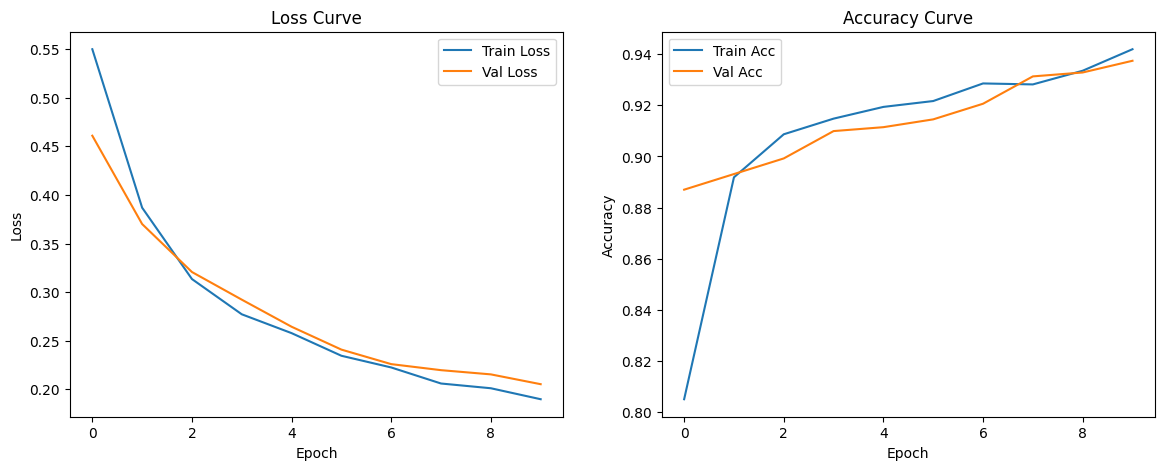

In [18]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [19]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in dataloaders["val"]:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        hoax       0.90      0.93      0.91       235
       valid       0.96      0.94      0.95       420

    accuracy                           0.94       655
   macro avg       0.93      0.94      0.93       655
weighted avg       0.94      0.94      0.94       655



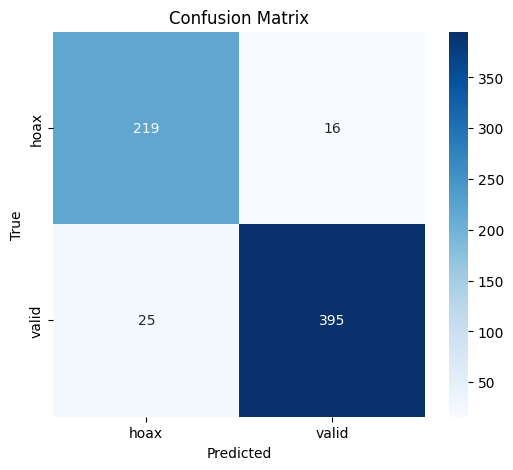

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


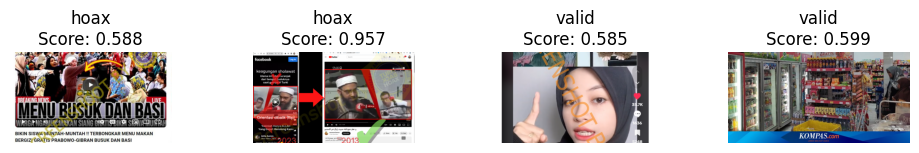

In [23]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch

def predict_image(image_path, model, class_names):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Apply the same transformations as validation data
    # val_transforms is defined in a previous cell
    input_tensor = val_transforms(image)
    # Add batch dimension (C, H, W) -> (1, C, H, W)
    input_batch = input_tensor.unsqueeze(0)

    # Move input to the same device as the model
    input_batch = input_batch.to(device)

    # Ensure model is in evaluation mode
    model.eval()

    with torch.no_grad():
        outputs = model(input_batch)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        # Get the predicted class index and its probability
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class_name = class_names[predicted_idx.item()]
        score = probabilities[predicted_idx.item()].item()

    return predicted_class_name, score


model.eval()
model.to(device)

image_paths = []
for root, _, files in os.walk(ROOT_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg",".webp")):
            image_paths.append(os.path.join(root, file))

if not image_paths:
    print("No images found in DATA_DIR. Please check your DATA_DIR path or image formats.")
else:
    # Ambil 3 gambar random (atau kurang jika tidak cukup)
    num_samples = min(4, len(image_paths))
    if num_samples == 0:
        print("Cannot sample images as no images were found.")
    else:
        sample_images = random.sample(image_paths, num_samples)

        # 4. Testing & visualisasi
        plt.figure(figsize=(12, 4))

        for i, img_path in enumerate(sample_images):
            # Use the existing PyTorch prediction function
            label, score = predict_image(img_path, model, class_names)

            # For displaying the image with matplotlib
            img_display = Image.open(img_path).convert("RGB")

            plt.subplot(3
                        , num_samples, i+1) # Adjust subplot based on actual number of samples
            plt.imshow(img_display)
            plt.title(f"{label}\nScore: {score:.3f}")
            plt.axis("off")

        plt.show()